# PCA vs DRR
This script compares the DRR and PCA performance for dimensionality reduction in the digits database.

In [1]:
# Reading the required toolboxes
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
# Estracting the data
X = digits.data

In [4]:
# Adding some small uniform noise to remove the quantization effect
X = X + np.random.rand(X.shape[0],X.shape[1])

(<matplotlib.image.AxesImage at 0x7f57182346a0>, (-0.5, 7.5, 7.5, -0.5))

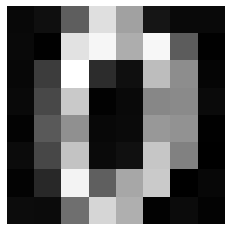

In [5]:
# Show the first ('0') data in image format
plt.imshow(np.reshape(X[0,:],(8,8)),cmap='gray'), plt.axis('off')

In [6]:
# Divide between train and test
Xtr, Xts, ytr, yts = train_test_split(X, X, test_size=0.5)

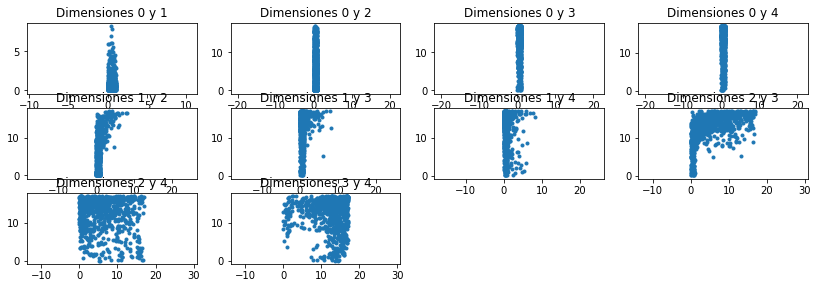

In [7]:
# Show pairs of the first 'd' dimensions in the original domain
plt.figure(figsize=(14,6))
ii=1
d = 5
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xtr[:,n1],Xtr[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        ii += 1

In [8]:
# Define the DRR model class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.kernel_ridge import KernelRidge

class DRR(BaseEstimator, TransformerMixin):
   
    def __init__(self,estimator_type="Poly"):
        # regressor
        if estimator_type=="Poly":        
            self.parameters = {'polynomialfeatures__degree':np.arange(1,7), 'ridge__alpha':[0.01,0.1,1,10]}
            self.model = make_pipeline(PolynomialFeatures(), Ridge())
        elif estimator_type=="KRR":        
            self.parameters = {'kernel':('linear', 'rbf'), "alpha": [1e0, 0.1, 1e-2, 1e-3],"gamma": np.logspace(-2, 2, 5)}
            self.model = KernelRidge()


    def fit_transform(self,X):
        # PCA
        self.m = np.mean(X, axis = 0)
        Xm = X - self.m[np.newaxis,:]
        cov_matrix = np.dot(Xm.T, Xm) / Xm.shape[0]
        evals, evecs = np.linalg.eigh(cov_matrix)   
        #ordenamos
        idx = np.argsort(-evals)
        self.evecs = evecs[:,idx]
        evals = evals[idx]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)

        # DRR
        Xdrr = Xpca.copy()

        self.models = []

        for n in np.arange(X.shape[1]-1,0,-1):
            
            clf = GridSearchCV(self.model, self.parameters)
            clf.fit(Xpca[:,0:n], Xpca[:,n])
            x_hat = clf.predict(Xpca[:,0:n])

            Xdrr[:,n] = Xpca[:,n]-x_hat
            self.models.append(clf)
            print(n)

        return Xdrr, Xpca

    def transform(self,X):
        # PCA
        Xm = X - self.m[np.newaxis,:]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)

        # DRR
        Xdrr = Xpca.copy()

        for n in np.arange(X.shape[1]-1,0,-1):
            ind_m = X.shape[1]-n-1
            x_hat = self.models[ind_m].predict(Xpca[:,0:n])
            Xdrr[:,n] = Xpca[:,n]-x_hat
            print(n)

        return Xdrr  

    def transform_pca(self,X):
        # PCA
        Xm = X - self.m[np.newaxis,:]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)    

        return Xpca

    def inverse(self,Xdrr):
        inv_Xdrr = Xdrr.copy()
        for n in np.arange(Xdrr.shape[1]-2,-1,-1):
            x_hat = self.models[n].predict(inv_Xdrr[:,0:Xdrr.shape[1]-n-1])
            inv_Xdrr[:,Xdrr.shape[1]-n-1] = inv_Xdrr[:,Xdrr.shape[1]-n-1] + x_hat
            print(n)  
        # PCA inv
        Xm_inv = np.dot(inv_Xdrr,self.evecs.T)
        X_inv = Xm_inv + self.m[np.newaxis,:]

        return X_inv

    def inverse_pca(self,Xpca):
        inv_Xpca = Xpca.copy()
        # PCA inv
        Xm_inv = np.dot(inv_Xpca,self.evecs.T)
        X_inv = Xm_inv + self.m[np.newaxis,:]

        return X_inv

In [9]:
# Generrating a DRR model instance using KRR for the regression step
DRR_model = DRR(estimator_type="KRR")

In [10]:
# Fit the model
Xdrr_tr, Xpca_tr = DRR_model.fit_transform(Xtr)

63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


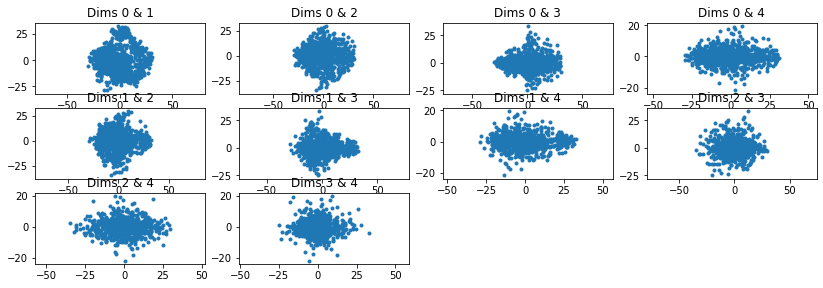

In [12]:
# Show pairs of the first 'd' dimensions in the DRR domain
plt.figure(figsize=(14,6))

d = 5

ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xdrr_tr[:,n1],Xdrr_tr[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        ii += 1

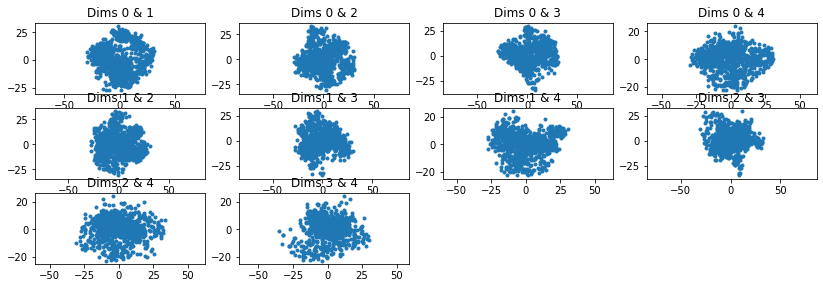

In [14]:
# Show pairs of the first 'd' dimensions in the PCA domain
plt.figure(figsize=(14,6))

d = 5

ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xpca_tr[:,n1],Xpca_tr[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        ii += 1

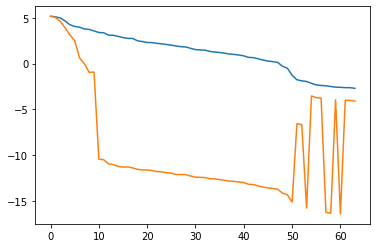

In [15]:
# Shows the variance in the transform domain (equivalent to MSE in the original domain) in logaritmic scale   
plt.figure
plt.plot(np.log(np.var(Xpca_tr,axis=0)))
plt.plot(np.log(np.var(Xdrr_tr,axis=0)))

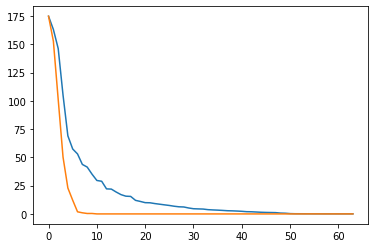

In [16]:
# Shows the variance in the transform domain (equivalent to MSE in the original domain)
plt.figure
plt.plot((np.var(Xpca_tr,axis=0)))
plt.plot((np.var(Xdrr_tr,axis=0)))

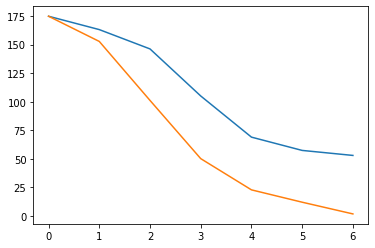

In [17]:
# Shows the variance in the transform domain (equivalent to MSE in the original domain)
# for the first NF features
NF = 7
plt.figure
plt.plot((np.var(Xpca_tr,axis=0)[0:NF]))
plt.plot((np.var(Xdrr_tr,axis=0)[0:NF]))

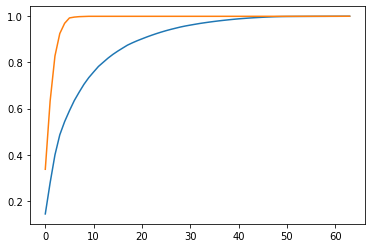

In [18]:
# Accumulated variance
plt.figure
plt.plot(np.cumsum(np.var(Xpca_tr,axis=0))/sum(np.var(Xpca_tr,axis=0)))
plt.plot(np.cumsum(np.var(Xdrr_tr,axis=0))/sum(np.var(Xdrr_tr,axis=0)))

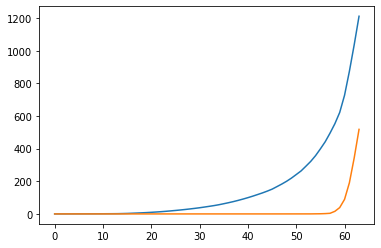

In [22]:
# Accumulated error
plt.figure
plt.plot(np.cumsum(np.sort(np.var(Xpca_tr,axis=0))))
plt.plot(np.cumsum(np.sort(np.var(Xdrr_tr,axis=0))))

### APPLY in test

In [23]:
Xdrr_ts = DRR_model.transform(Xts)

63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [24]:
# PCA
Xpca_ts = DRR_model.transform_pca(Xts)

# DIM REDUCTION

In [27]:
# Reduce the dimensionality to Nf features
Nf = 3
red_Xdrr_ts = Xdrr_ts.copy()
red_Xdrr_ts[:,Nf:] = 0
inv_red_Xdrr_ts = DRR_model.inverse(red_Xdrr_ts)

62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


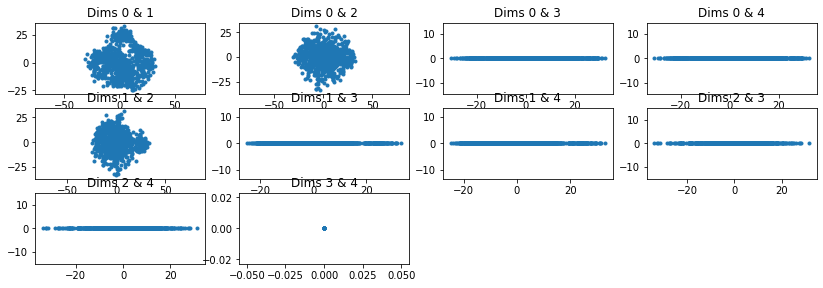

In [28]:
# Show pairs of the first 'd' dimensions in the DRR reduced domain
plt.figure(figsize=(14,6))

d = 5

ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(red_Xdrr_ts[:,n1],red_Xdrr_ts[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        ii += 1

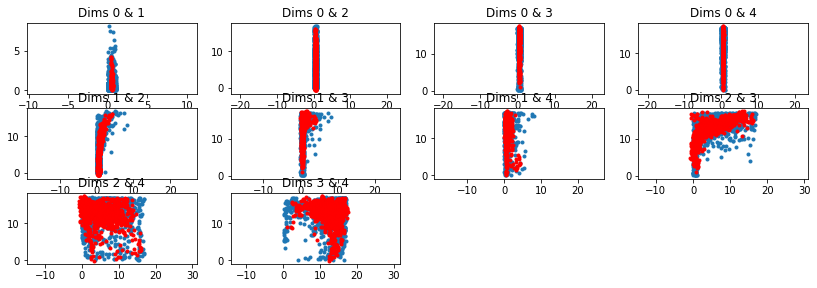

In [29]:
# Show pairs of the first 'd' dimensions in the DRR inverted/Original domain
plt.figure(figsize=(14,6))

d = 5

ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xts[:,n1],Xts[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        plt.plot(inv_red_Xdrr_ts[:,n1],inv_red_Xdrr_ts[:,n2],'r.')
        ii += 1

In [30]:
# Invert PCA
red_Xpca_ts = Xpca_ts.copy()
red_Xpca_ts[:,Nf:] = 0
inv_red_Xpca_ts = DRR_model.inverse_pca(red_Xpca_ts)


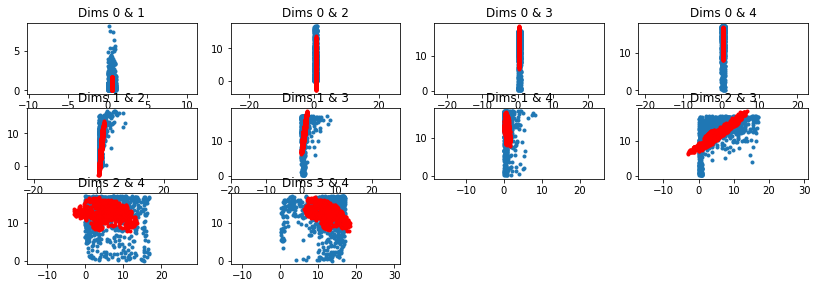

In [31]:
# Show pairs of the first 'd' dimensions in the PCA inverted/Original domain
plt.figure(figsize=(14,6))

d = 5

ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xts[:,n1],Xts[:,n2],'.'), plt.axis('equal'), plt.title('Dims ' + np.str(n1) + ' & ' + np.str(n2))
        plt.plot(inv_red_Xpca_ts[:,n1],inv_red_Xpca_ts[:,n2],'r.')
        ii += 1


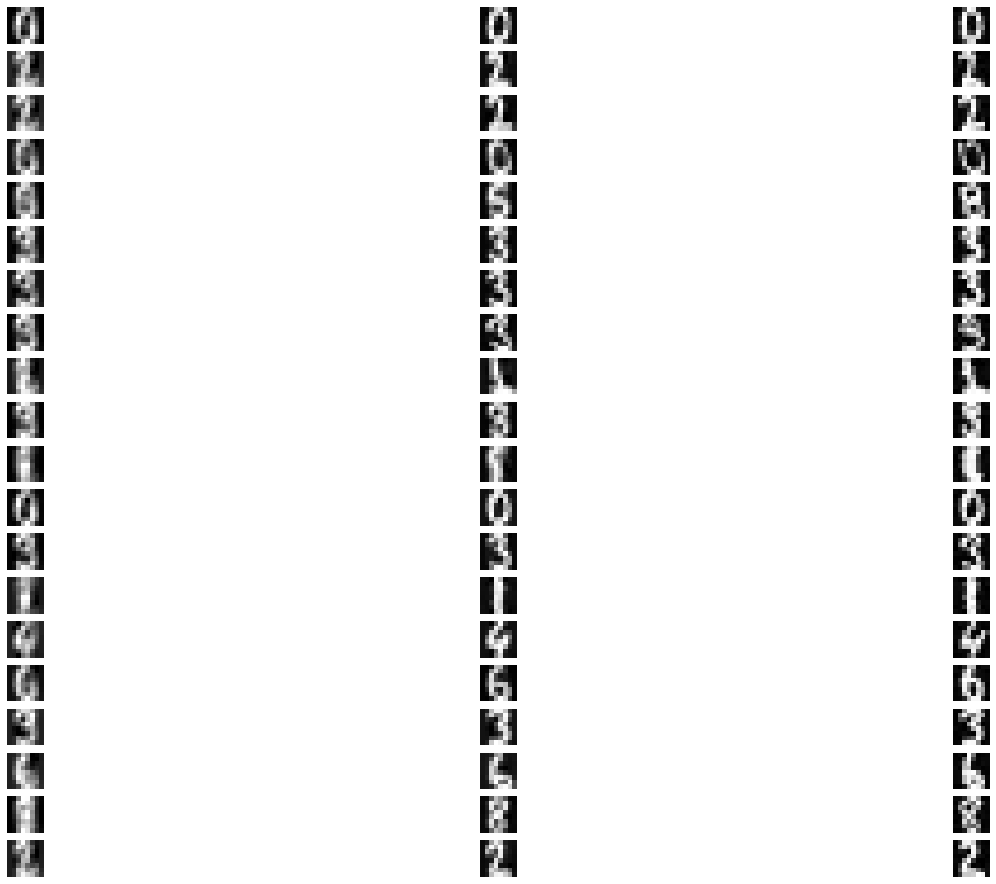

In [32]:
# SHOW RECONSTRUCTED IMAGES
NN = 20
plt.figure(figsize=(24,16))
for ii in np.arange(1,3*NN,3):
    
    plt.subplot(NN,3,ii)
    plt.imshow(np.reshape(inv_red_Xpca_ts[ii,:],(8,8)),cmap='gray'), plt.axis('off')

    plt.subplot(NN,3,ii+1)
    plt.imshow(np.reshape(inv_red_Xdrr_ts[ii,:],(8,8)),cmap='gray'), plt.axis('off')

    plt.subplot(NN,3,ii+2)
    plt.imshow(np.reshape(Xts[ii,:],(8,8)),cmap='gray'), plt.axis('off')